In [2]:
%load_ext autoreload
%autoreload 2

import os
import json
import numpy as np
import copy
import matplotlib.pyplot as plt
from cosmos_helper_funcs import get_stacks, label_plot, cosmos_gain_dict, get_mean_images

In [3]:
flat_stack_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Intrapixel Capacitance'
flat_stack = get_stacks(flat_stack_folder)[0]

Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Intrapixel Capacitance/calibrated_CMS_RS_light_3000ms_-25C 2024-10-03 10_14_42.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Intrapixel Capacitance/CMS_RS_light_3000ms_-25C 2024-10-03 10_14_42.fits


In [4]:
print(flat_stack['imagestack'].shape)

(25, 8120, 8120)


In [5]:
flat_stack = flat_stack['imagestack']
# Get difference images by pairing up the images. Stack has 25 frames, so 12 pairs.
diff_images = np.zeros((12, flat_stack.shape[1], flat_stack.shape[2]))
for i in range(12):
    diff_images[i] = flat_stack[2*i+1] - flat_stack[2*i]

In [6]:
def get_autocorr_matrix(diff_images, matrix_size=3):
    """
    Compute the autocorrelation matrix of a set of difference images.
    
    Parameters
    ----------
    diff_images : list of numpy arrays
        The difference images to compute the autocorrelation matrix of.
    max_sep : int
        The maximum separation to compute the autocorrelation matrix up to.
        
    Returns
    -------
    autocorr_matrix : numpy array
        The autocorrelation matrix of the difference images.
    """
    autocorr_matrix = np.zeros((matrix_size, matrix_size))
    for i in range(-matrix_size//2 + 1, matrix_size//2 + 1):
        for j in range(-matrix_size//2 + 1, matrix_size//2 + 1):
            print(i, j)
            shifted_array = np.roll(np.roll(diff_images, i, axis=1), j, axis=2)
            if i < 0:
                shifted_array = shifted_array[:,:i,:]
                diff_images = diff_images[:,:i,:]
            elif i > 0:
                shifted_array = shifted_array[:,i:,:]
                diff_images = diff_images[:,i:,:]
            if j < 0:
                shifted_array = shifted_array[:,:,:j]
                diff_images = diff_images[:,:,:j]
            elif j > 0:
                shifted_array = shifted_array[:,:,j:]
                diff_images = diff_images[:,:,j:]
            product_img = diff_images * shifted_array
            autocorr_matrix[i + matrix_size//2, j + matrix_size//2] = np.mean(product_img)
            # print(i, j)
            # autocorr_matrix[i, j] = np.mean(diff_images[:, :len(diff_images[1]) - i, :len(diff_images[2]) - j] *
            #                                 diff_images[:, i:, j:])
    autocorr_matrix = autocorr_matrix / np.sum(autocorr_matrix) * 100
    # Coupling matrix is the same as autocorr_matrix, but percentages are halved.
    coupling_matrix = autocorr_matrix / 2
    center_fraction = 100 - (np.sum(coupling_matrix) - coupling_matrix[matrix_size//2, matrix_size//2])
    coupling_matrix[matrix_size//2, matrix_size//2] = center_fraction
    return autocorr_matrix, coupling_matrix

In [7]:
autocorr_matrix = get_autocorr_matrix(diff_images, matrix_size=5)

-2 -2
-2 -1
-2 0
-2 1
-2 2
-1 -2
-1 -1
-1 0
-1 1
-1 2
0 -2
0 -1
0 0
0 1
0 2
1 -2
1 -1
1 0
1 1
1 2
2 -2
2 -1
2 0
2 1
2 2


In [12]:
coupling_matrix = autocorr_matrix[0] / 2
center_fraction = 100 - (np.sum(coupling_matrix) - coupling_matrix[2, 2])
coupling_matrix[2, 2] = center_fraction

TypeError: Invalid shape (2, 5, 5) for image data

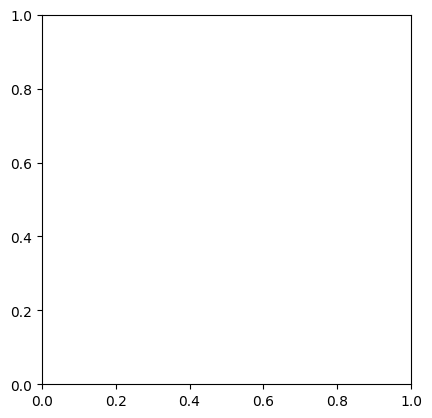

In [13]:
# Make a heat map with the autocorrelation array. Put the associated value on each square.
fig, ax = plt.subplots()
cax = ax.imshow(autocorr_matrix,norm='log' )
fig.colorbar(cax, label='Autocorrelation (%)')
for i in range(autocorr_matrix.shape[0]):
    for j in range(autocorr_matrix.shape[1]):
        if i == 2 and j == 2:
            ax.text(j, i, f'{autocorr_matrix[i, j]:.3f}', ha='center', va='center', color='black')
        else:
            ax.text(j, i, f'{autocorr_matrix[i, j]:.3f}', ha='center', va='center', color='white')
# Make the ticks go from -2 to 2 instead of 0 to 4
ax.set_xticks(np.arange(autocorr_matrix.shape[1]))
ax.set_yticks(np.arange(autocorr_matrix.shape[0]))
ax.set_xticklabels(np.arange(-autocorr_matrix.shape[1]//2+1, autocorr_matrix.shape[1]//2+1))
ax.set_yticklabels(np.arange(-autocorr_matrix.shape[0]//2+1, autocorr_matrix.shape[0]//2+1))
plt.show()

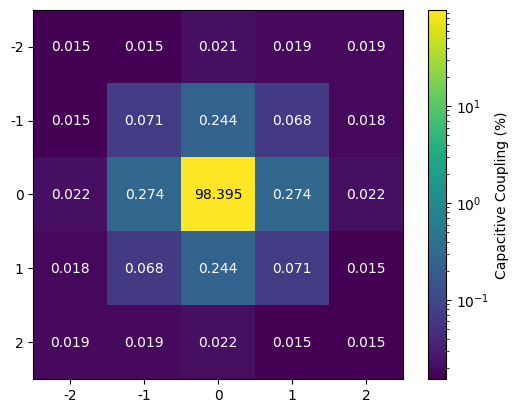

: 

In [ ]:
# Make a heat map with the couplingelation array. Put the associated value on each square.
fig, ax = plt.subplots()
cax = ax.imshow(coupling_matrix,norm='log' )
fig.colorbar(cax, label='Capacitive Coupling (%)')
for i in range(coupling_matrix.shape[0]):
    for j in range(coupling_matrix.shape[1]):
        if i == 2 and j == 2:
            ax.text(j, i, f'{coupling_matrix[i, j]:.3f}', ha='center', va='center', color='black')
        else:
            ax.text(j, i, f'{coupling_matrix[i, j]:.3f}', ha='center', va='center', color='white')
# Make the ticks go from -2 to 2 instead of 0 to 4
ax.set_xticks(np.arange(coupling_matrix.shape[1]))
ax.set_yticks(np.arange(coupling_matrix.shape[0]))
ax.set_xticklabels(np.arange(-coupling_matrix.shape[1]//2+1, coupling_matrix.shape[1]//2+1))
ax.set_yticklabels(np.arange(-coupling_matrix.shape[0]//2+1, coupling_matrix.shape[0]//2+1))
plt.show()